In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np

In [92]:
# Microscope: Zeiss LSM 510 Meta

# Objective lens: Plan-Apochromat 63x/1.4 (oil)

# Pixel size (microns): 0.19 x 0.19

# Time step (min): 10

In [5]:
img = cv2.cvtColor(cv2.imread('./DIC-C2DH-HeLa/01/t000.tif'),cv2.COLOR_BGR2GRAY)

In [94]:
img.shape

(512, 512)

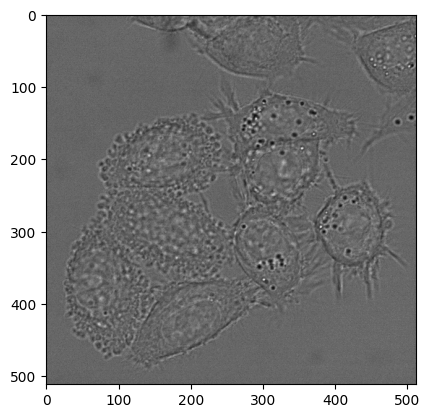

In [6]:
plt.imshow(img,cmap='gray')

In [1]:
import torch.nn as nn

class UNet(nn.Module):
    def convolute(self,in_channels,out_channels,kernel_size):
        layers = [
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,padding=1,stride=1),
            nn.ReLU(inplace=True),
            ]
        return layers

    def __init__(self):
        super(UNet,self).__init__()
        # Downsampling
        self.conv1 =  nn.Sequential(*self.convolute(3,64,3),*self.convolute(64,64,3))
        self.pool1 = nn.Sequential(nn.MaxPool2d(kernel_size=2))
        self.conv2 = nn.Sequential(*self.convolute(64,128,3),*self.convolute(128,128,3))
        self.pool2 = nn.Sequential(nn.MaxPool2d(kernel_size=2))
        self.conv3 = nn.Sequential(*self.convolute(128,256,3),*self.convolute(256,256,3))
        self.pool3 = nn.Sequential(nn.MaxPool2d(kernel_size=2))
        self.conv4 = nn.Sequential(*self.convolute(256,512,3),*self.convolute(512,512,3))
        self.pool4 = nn.Sequential(nn.MaxPool2d(kernel_size=2))
        self.bottleneck = nn.Sequential(*self.convolute(512,1024,3),*self.convolute(1024,1024,3))
        # Upsampling
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4_up = nn.Sequential(*self.convolute(1024, 512, 3), *self.convolute(512, 512, 3))  # Concatenate skip

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3_up = nn.Sequential(*self.convolute(512, 256, 3), *self.convolute(256, 256, 3))  # Concatenate skip

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2_up = nn.Sequential(*self.convolute(256, 128, 3), *self.convolute(128, 128, 3))  # Concatenate skip

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1_up = nn.Sequential(*self.convolute(128, 64, 3), *self.convolute(64, 64, 3))  # Concatenate skip
        
        # Final segmentation map (outputting the same number of channels as the input, or classes)
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, z):
        # Downsampling
        conv1_out = self.conv1(z)
        x = self.pool1(conv1_out)
        conv2_out = self.conv2(x)
        x = self.pool2(conv2_out)
        conv3_out = self.conv3(x)
        x = self.pool3(conv3_out)
        conv4_out = self.conv4(x)
        x = self.pool4(conv4_out)
        x = self.bottleneck(x)
        
        # Upsampling with skip connections
        x = self.upconv4(x)
        connection1 = torch.cat([x, conv4_out], dim=1)  # Skip connection
        x = self.conv4_up(connection1)
        x = self.upconv3(x)
        connection2 = torch.cat([x, conv3_out], dim=1)  
        x = self.conv3_up(connection2)
        x = self.upconv2(x)
        connection3 = torch.cat([x, conv2_out], dim=1)  
        x = self.conv2_up(connection3)
        x = self.upconv1(x)
        connection4 = torch.cat([x, conv1_out], dim=1)
        x = self.conv1_up(connection4)
        return self.final_conv(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024464183..0.14578313].


Output shape: torch.Size([1, 3, 512, 512])


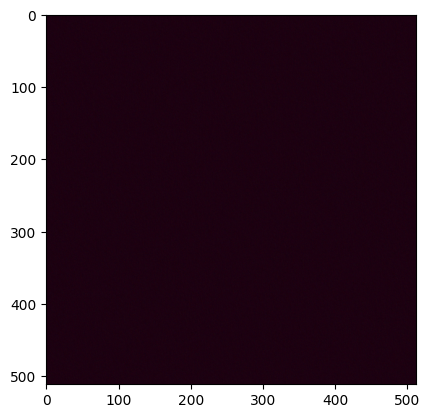

In [8]:
# Test
unet = UNet()
input_tensor = torch.randn(1,3,512,512)

output = unet(input_tensor)
print(f"Output shape: {output.shape}")
plt.imshow(output.detach().squeeze().numpy().T)


In [98]:
import os

# Specify the directory containing the mask images
mask_dir = "./DIC-C2DH-HeLa/02_ST/SEG"

# Get all files in the mask directory
mask_files = sorted(os.listdir(mask_dir))

# Iterate through each file and rename it in place
for idx, filename in enumerate(mask_files):
    # Create the full old file path
    old_filepath = os.path.join(mask_dir, filename)

    # Define a new filename with a prefix or numbering (in the same directory)
    new_filename = f"t00{idx}.tif" if idx<10 else f"t0{idx}.tif"  # Rename to mask_1.png, mask_2.png, etc.
    
    # Create the new file path (same directory, new name)
    new_filepath = os.path.join(mask_dir, new_filename)
    
    # Rename the file
    os.rename(old_filepath, new_filepath)
    
    print(f"Renamed {filename} to {new_filename}")

Renamed t000.tif to t000.tif
Renamed t001.tif to t001.tif
Renamed t002.tif to t002.tif
Renamed t003.tif to t003.tif
Renamed t004.tif to t004.tif
Renamed t005.tif to t005.tif
Renamed t006.tif to t006.tif
Renamed t007.tif to t007.tif
Renamed t008.tif to t008.tif
Renamed t009.tif to t009.tif
Renamed t010.tif to t010.tif
Renamed t011.tif to t011.tif
Renamed t012.tif to t012.tif
Renamed t013.tif to t013.tif
Renamed t014.tif to t014.tif
Renamed t015.tif to t015.tif
Renamed t016.tif to t016.tif
Renamed t017.tif to t017.tif
Renamed t018.tif to t018.tif
Renamed t019.tif to t019.tif
Renamed t020.tif to t020.tif
Renamed t021.tif to t021.tif
Renamed t022.tif to t022.tif
Renamed t023.tif to t023.tif
Renamed t024.tif to t024.tif
Renamed t025.tif to t025.tif
Renamed t026.tif to t026.tif
Renamed t027.tif to t027.tif
Renamed t028.tif to t028.tif
Renamed t029.tif to t029.tif
Renamed t030.tif to t030.tif
Renamed t031.tif to t031.tif
Renamed t032.tif to t032.tif
Renamed t033.tif to t033.tif
Renamed t034.t

In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
class HeLaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])  
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")  # Convert mask to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Example usage:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

dataset = HeLaDataset(image_dir="./cell images/images", mask_dir="./cell images/segments", transform=transform)

In [10]:
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
from tqdm import tqdm

model = UNet()  # Assuming your UNet model is defined
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss for segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4,betas=[0.5,0.999])

# Training Loop
num_epochs = 10


for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Wrap the train_loader with tqdm
    with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]") as pbar:
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            
            # Use sigmoid activation for output because BCELoss expects probabilities
            outputs = torch.sigmoid(outputs)
            
            # Reshape outputs and masks to have the same shape
            outputs = outputs.view(-1)
            masks = masks.view(-1)
            
            # Compute the loss
            loss = criterion(outputs, masks)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update the progress bar
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)  # Increment the progress bar by one
            
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

print("Training complete!")

In [19]:
torch.save(model.state_dict(),'./weights/UNet_HeLa.pt')
torch.save(model,'./weights/UNet_HeLa.pth')


C:\Users\vishw\AppData\Local\Temp\ipykernel_31328\1346290806.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./weights/UNet_HeLa.pt'))

(512, 512)


Text(0.5, 1.0, 'Predicted Segmentation Mask')

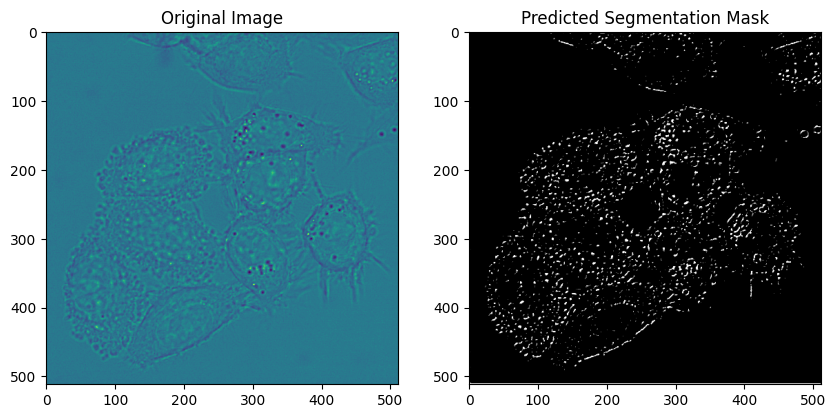

In [33]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load the model's architecture (assuming you have the UNet class)
model = UNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Load the model weights
model.load_state_dict(torch.load('./weights/UNet_HeLa.pt'))
model.eval()  # Set the model to evaluation mode


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Load and preprocess the test image
test_image_path = './DIC-C2DH-HeLa/01/t000.tif'  # Replace with the path to your test image
image = Image.open(test_image_path).convert("RGB")
image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Forward pass through the model
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(image)
    output = torch.sigmoid(output)  # Apply sigmoid to get probabilities
    output = output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU

# Threshold the output to get the binary mask (threshold can be adjusted)
segmentation = output > 0.5  # Example threshold

mask = np.zeros(segmentation.shape, dtype=np.uint8)
mask[segmentation == 1]=255
mask[segmentation == 0]=0


# Visualize the result
plt.figure(figsize=(10, 5))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(Image.open(test_image_path))
plt.title("Original Image")
print(segmentation[0].shape)
# Show segmentation mask
plt.subplot(1, 2, 2)
segmentation = segmentation.astype(int)
segmentation = np.rot90(cv2.flip(cv2.flip(mask.T,0),-1),1)

plt.imshow(cv2.cvtColor(segmentation,cv2.COLOR_RGB2GRAY),cmap='gray')  # The segmentation mask
plt.savefig('./demo.jpg')
plt.title("Predicted Segmentation Mask")



In [32]:
# 10 epochs model works best